# Week 15: Image Caption
The goal of image captioning is to convert a given input image into a natural language description.   
In this tutorial, we only introduce you with translation from image to sentence.   
We would also introduce you to embedding attention into image translation, which boosts performance.  

Thus, outline would be something below

0. Before you step into this tutorials
1. Main structure of image caption  
    1.1 From language translation to image caption   
    1.2 Module in image caption model  
    1.3 Train and Evaluate  
2. Embed attention mechanism into image cpation model  
    2.1 Soft attention and its implementation  
    2.2 Train and Evaluate   
3. Beam search when inference
    
This introduction mainly refer to [a-PyTorch-Tutorial-to-Image-Captioning](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/)  
And strongly recommend yoy guys to read papers below to make deeper understand.

1. [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf)
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attentio](https://arxiv.org/pdf/1502.03044.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import torch.nn as nn
import torchvision
from torch.nn.utils.rnn import pack_padded_sequence
from scipy.misc import imread, imresize
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from PIL import Image

sys.path.append("./src")
from action import AverageMeter #Metric class defined in src/action, read code when availabel 
from dataset import Dataset #Dataset class defined in src/action, read code when availabel

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 0. Before you step into this tutorials
We have asumed that you have learnt Naive Seq2seq model which is implemented in Recurren-2.   
1. In this tutorials, we use [Flickr8k](https://illinois.edu/fb/sec/1713398), a simple but useful dataset for image caption, which contains images and corresponding captions. For simplicity, we haved sampled images and corresponding captions and formed a mini-Flickr8k containing 400 items for train dataset, 100 for val datasets. Thus, we don't guarantee performance. However,  method is correct.
2. This tutorials focus on implementations of model and training phase. If you dont't want to just play with a toy, read dataset.py for how to deal with data.

## 1. Main structure of image caption

## 1.1 From language translation to image caption
Language translation means to translate a kind of language to another.   
When it comes to image caption, we could take image as a special kind of "language".   
In this ways,  we could
follow the method that we apply in translation tasks.  
In **Week11**, we have implemented a 
naive Seq2seq models, a model that generates sequences will use an Encoder to encode the input into a fixed form and a Decoder to decode it, word by word, into a sequence.   
In translation task, we usuallly use RNN as both the encoder and decoder.   
In image caption, we use CNN as the encoders instead of RNN.  

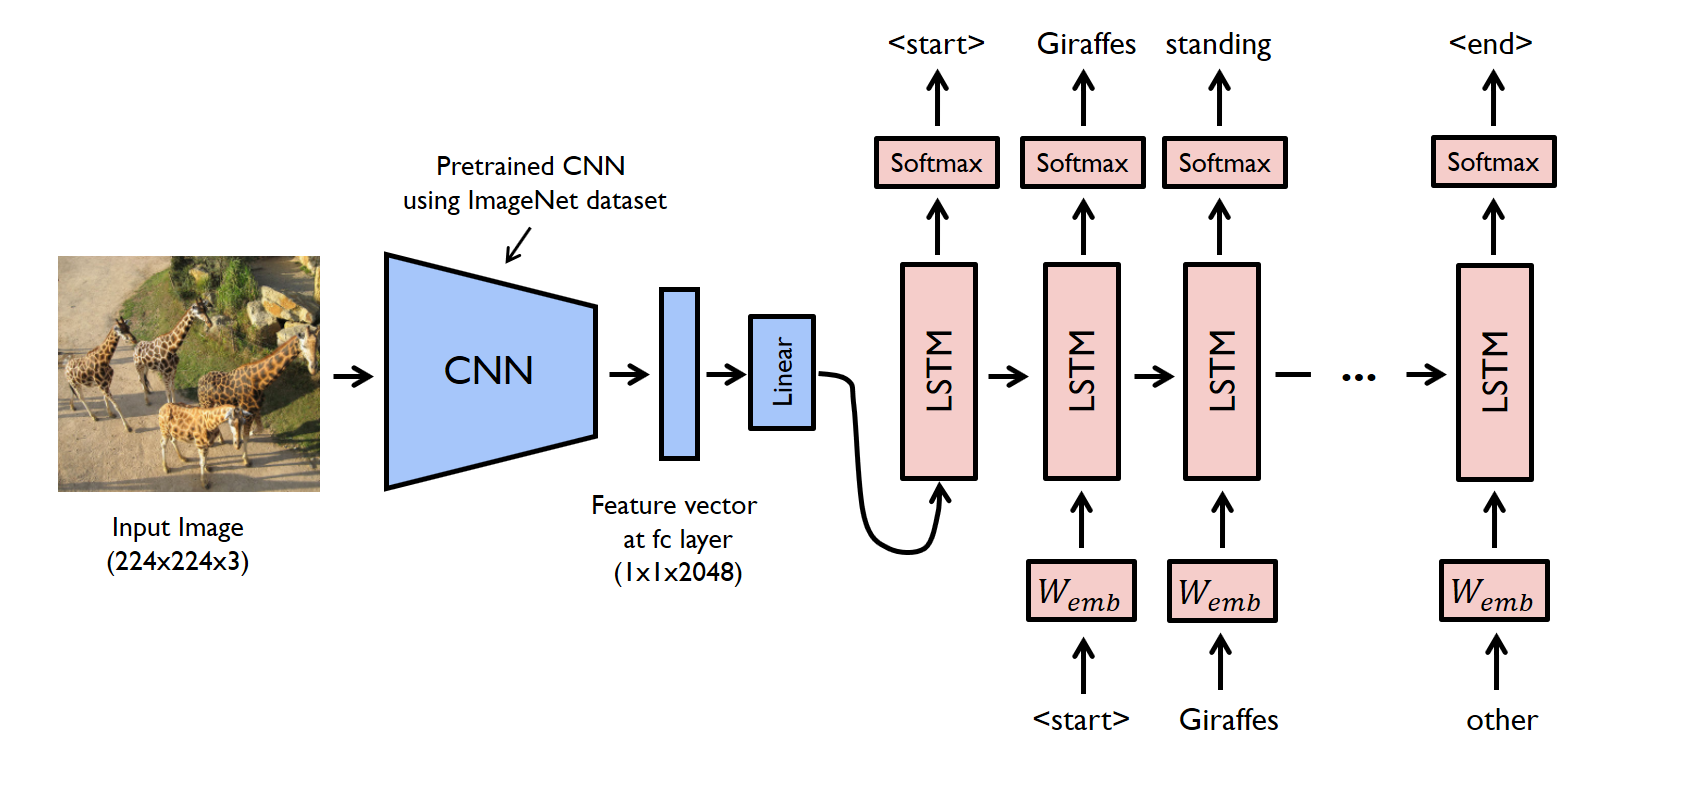

## 1.2 Module in image caption model  

Encoder would be implemented as below

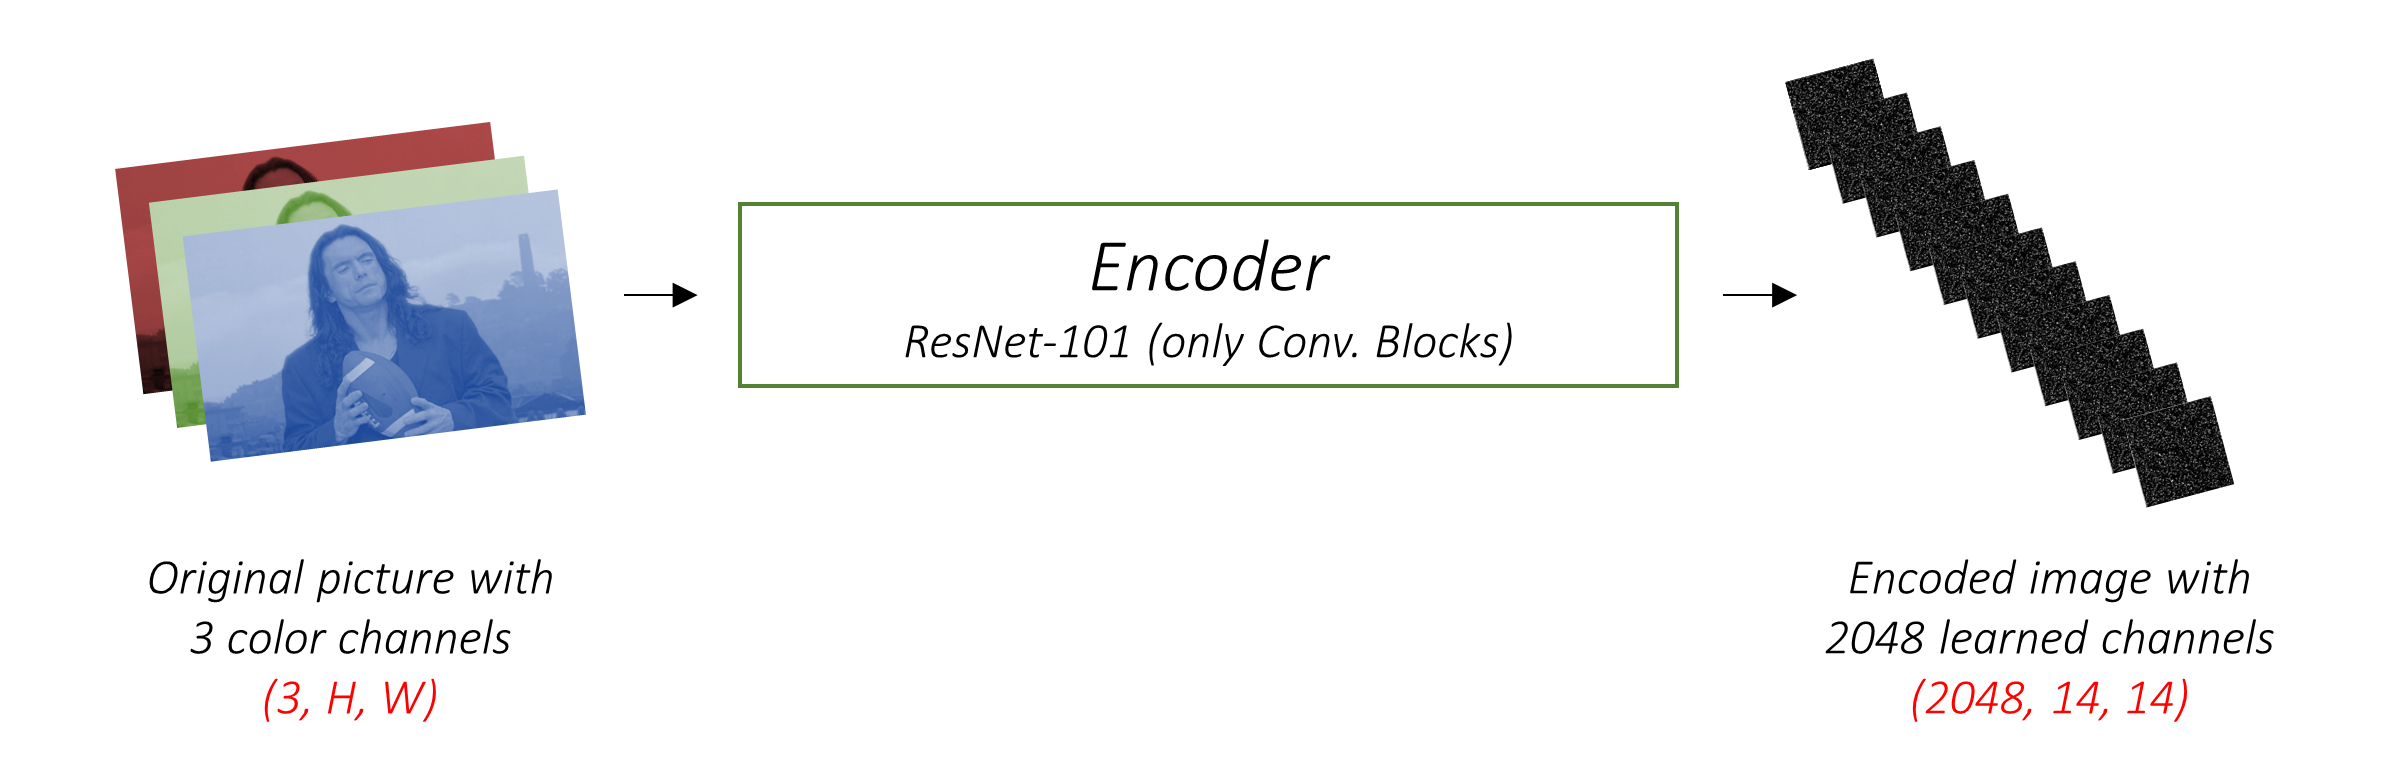

In [3]:
class Encoder(nn.Module):
    """Encoder
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.encoded_image_size = encoded_image_size
        self.backbone = self.get_backbone()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        # (batch_size, 2048, image_size/32, image_size/32)
        out = self.backbone(images)
        # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = self.adaptive_pool(out)
        # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.permute(0, 2, 3, 1)
        return out

    def get_backbone(self):
        """Get backbone"""
        # Resnet18 as backbone
        resnet = torchvision.models.resnet101(pretrained=True)
        # Remove linear and pool layers (since we're not doing classification)
        models = list(resnet.children())[:-2]
        backbone = nn.Sequential(*models)
        return backbone

Decoder would implement as below

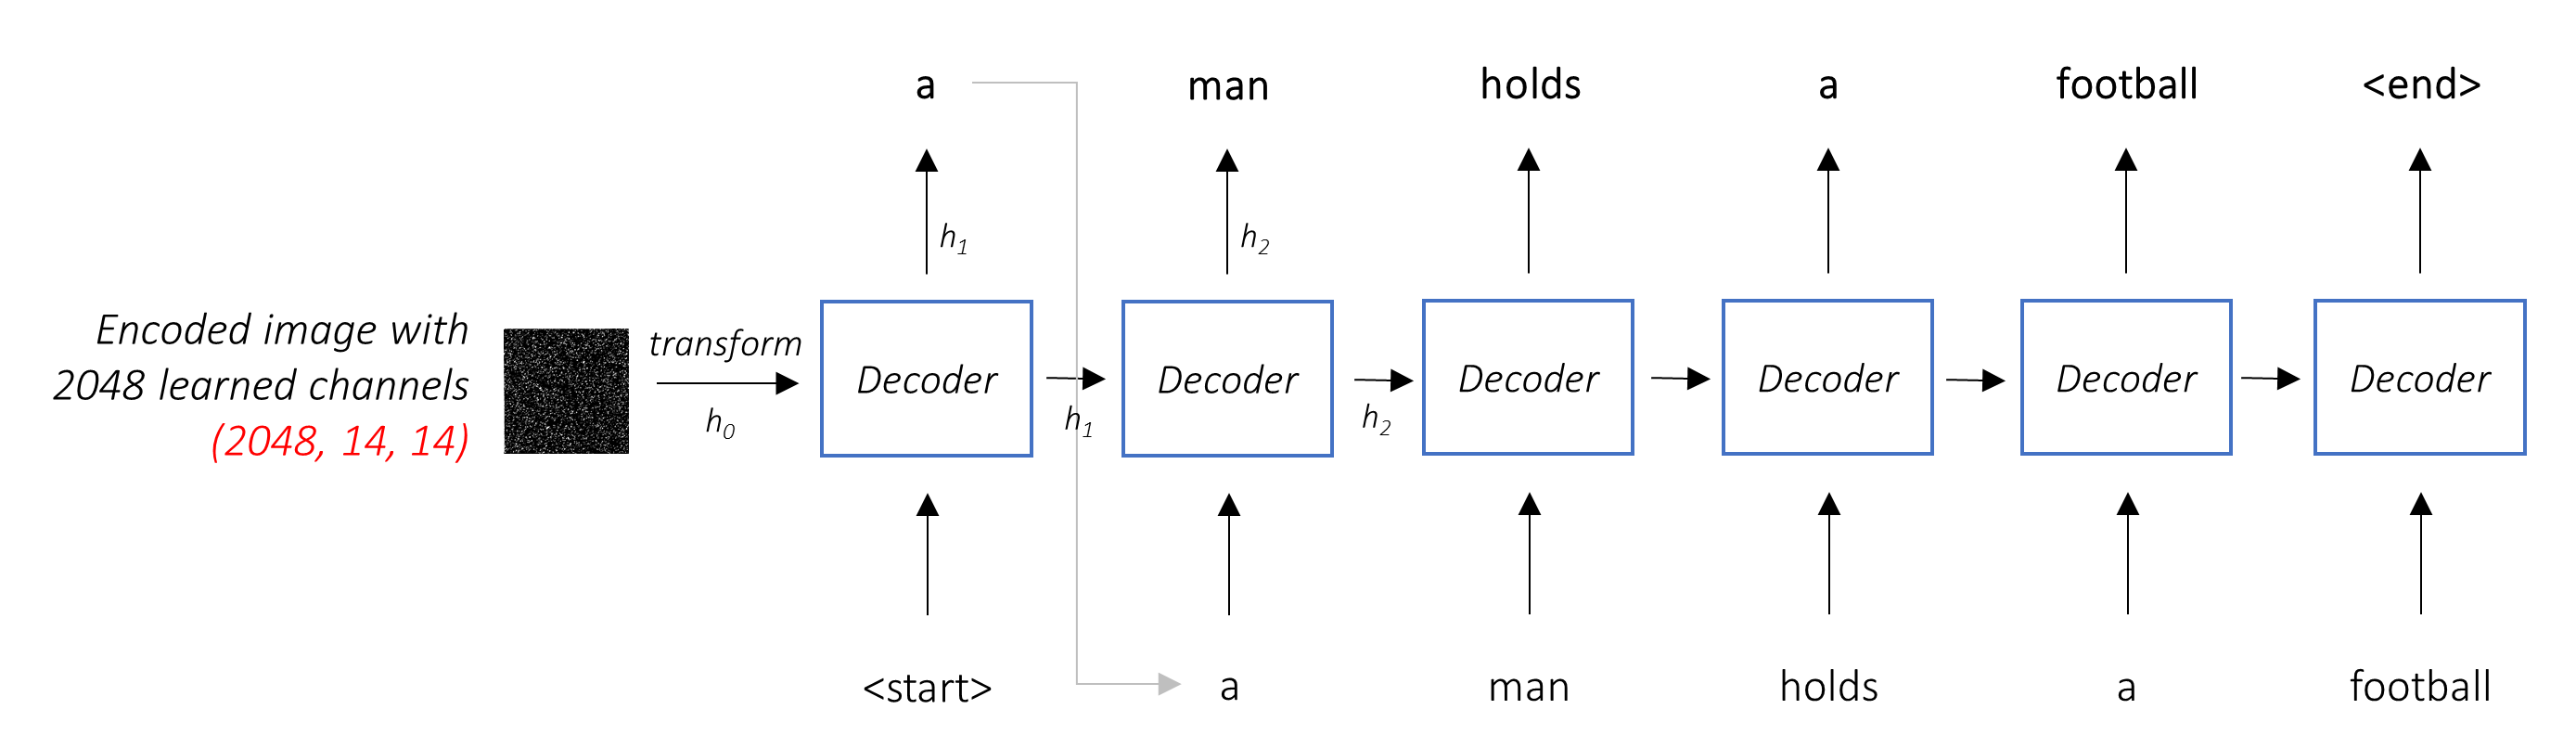

In [4]:
class Decoder(nn.Module):
    """Decoder
    """
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        #self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.decode_step = nn.LSTMCell(embed_dim, decoder_dim)
        # linear layer to find initial hidden state of LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        # linear layer to find initial cell state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        # linear layer to find scores over vocabulary
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_weights()

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        device = encoder_out.device

        # Flatten image
        # (batch_size, num_pixels, encoder_dim)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).\
            sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        # (batch_size, max_caption_length, embed_dim)
        embeddings = self.embedding(encoded_captions)

        # Initialize LSTM state
        # (batch_size, decoder_dim)
        h, c = self.init_hidden_state(encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).\
            to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            h, c = self.decode_step(
                embeddings[:batch_size_t, t, :],
                (h[:batch_size_t], c[:batch_size_t]))

            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds

        return predictions, encoded_captions, decode_lengths, None, sort_ind

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        # (batch_size, decoder_dim)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

## 1.3 Train and Evaluate
Functions introduce here.

```
 clip_gradient: clip gradient
 train_epoch: Performs one epoch's training.
 eval_epoch: Performs one epoch's validation.
 run: Main function to run
```

In [5]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group["params"]:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [6]:
def train_epoch(train_loader, encoder, decoder, loss_fn,
                    encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    """
    encoder.train()
    decoder.train()

    losses = AverageMeter()

    for idx, (imgs, caps, caplens) in enumerate(train_loader):
        torch.cuda.empty_cache()
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas,  sort_ind = \
            decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        #TODO
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
        scores = scores[0]
        targets = targets[0]

        # Calculate loss
        loss = loss_fn(scores, targets)

        if alphas is not None:
            loss += (1 - alphas.sum(dim=1) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        losses.update(loss.item(), sum(decode_lengths))

        if idx % 100 == 0:
            print(">>Epoch(Train): [{0}][{1}/{2}]\tLoss {loss.avg:.4f}".format
                  (epoch, idx, len(train_loader), loss=losses))

In [7]:
def eval_epoch(val_loader, encoder, decoder, loss_fn, epoch):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    """
    decoder.eval()
    encoder.eval()

    losses = AverageMeter()

    with torch.no_grad():
        for idx, (imgs, caps, caplens, allcaps) in enumerate(val_loader):
            torch.cuda.empty_cache()
            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = \
                decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all
            # words after <start>, up to <end>
            targets = caps_sorted[:, 1:]
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)
            scores = scores[0]
            targets = targets[0]

            # Calculate loss
            loss = loss_fn(scores, targets)

            if alphas is not None:
                loss += (1 - alphas.sum(dim=1) ** 2).mean()

            losses.update(loss.item(), sum(decode_lengths))

            if idx % 100== 0:
                print(">>Epoch(Eval): [{epoch}][{idx}/{iters}]\tLoss {loss.avg:.4f}".format(
                      epoch=epoch, idx=idx, iters=len(val_loader),
                      loss=losses))

In [8]:
def run(encoder, decoder):
    """Main function to run"""
    encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
    decoder_lr = 4e-4  # learning rate for decoder
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=encoder_lr)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=decoder_lr)

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)

    train_loader, val_loader = dataset.get_dataloader()

    for epoch in range(n_epochs):
        train_epoch(train_loader, encoder, decoder, loss_fn,
                         encoder_optimizer, decoder_optimizer, epoch)
        eval_epoch(val_loader, encoder, decoder, loss_fn, epoch)

In [12]:
# Run your code
batch_size = 2
n_epochs = 5
embed_dim = 512 # dimension of word embeddings
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
grad_clip = 5
dataset = Dataset(batch_size=batch_size)
word_map = dataset.get_word_map()
rev_word_map = dataset.get_rev_word_map()

encoder = Encoder()
decoder = Decoder(embed_dim=embed_dim,
                  decoder_dim=decoder_dim,
                  vocab_size=len(word_map),
                  dropout=dropout)
run(encoder, decoder)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jovyan/.torch/models/resnet101-5d3b4d8f.pth
100.0%


>>Epoch(Train): [0][0/250]	Loss 7.8751
>>Epoch(Train): [0][100/250]	Loss 5.8304
>>Epoch(Train): [0][200/250]	Loss 5.4424
>>Epoch(Eval): [0][0/250]	Loss 4.5680
>>Epoch(Eval): [0][100/250]	Loss 4.8611
>>Epoch(Eval): [0][200/250]	Loss 4.8019
>>Epoch(Train): [1][0/250]	Loss 4.3556
>>Epoch(Train): [1][100/250]	Loss 4.6011
>>Epoch(Train): [1][200/250]	Loss 4.5651
>>Epoch(Eval): [1][0/250]	Loss 4.1345
>>Epoch(Eval): [1][100/250]	Loss 4.5108
>>Epoch(Eval): [1][200/250]	Loss 4.5510
>>Epoch(Train): [2][0/250]	Loss 4.3696
>>Epoch(Train): [2][100/250]	Loss 4.1567
>>Epoch(Train): [2][200/250]	Loss 4.1520
>>Epoch(Eval): [2][0/250]	Loss 3.9866
>>Epoch(Eval): [2][100/250]	Loss 4.3497
>>Epoch(Eval): [2][200/250]	Loss 4.3477
>>Epoch(Train): [3][0/250]	Loss 3.8882
>>Epoch(Train): [3][100/250]	Loss 3.8160
>>Epoch(Train): [3][200/250]	Loss 3.8161
>>Epoch(Eval): [3][0/250]	Loss 3.4088
>>Epoch(Eval): [3][100/250]	Loss 4.3168
>>Epoch(Eval): [3][200/250]	Loss 4.3274
>>Epoch(Train): [4][0/250]	Loss 3.5258
>>Epo

## 作业 1
1. 训练过程中使用了什么 Loss function ？ 

答：训练过程中使用了Cross Entropy Loss，即交叉熵损失函数。

2. 为什么要使用 pack_padded_sequence？

答：对于LSTM的输入每一批中的不同文本可能长度不一样，我们需要给每段文本填充至相同长度，然后再输入到LSTM中。同时，LSTM可以根据`pack_padded_sequence`获得填充的信息，从而优化训练保证模型训练的精度。

3. 使用gradient clip是解决哪个模型带来的问题（Hints:RNN面对序列过长的时候容易产生梯度消失） 

答：Decoder中的LSTM。

## 2. Embed attention mechanism into image cpation mode

Whole picture of the model

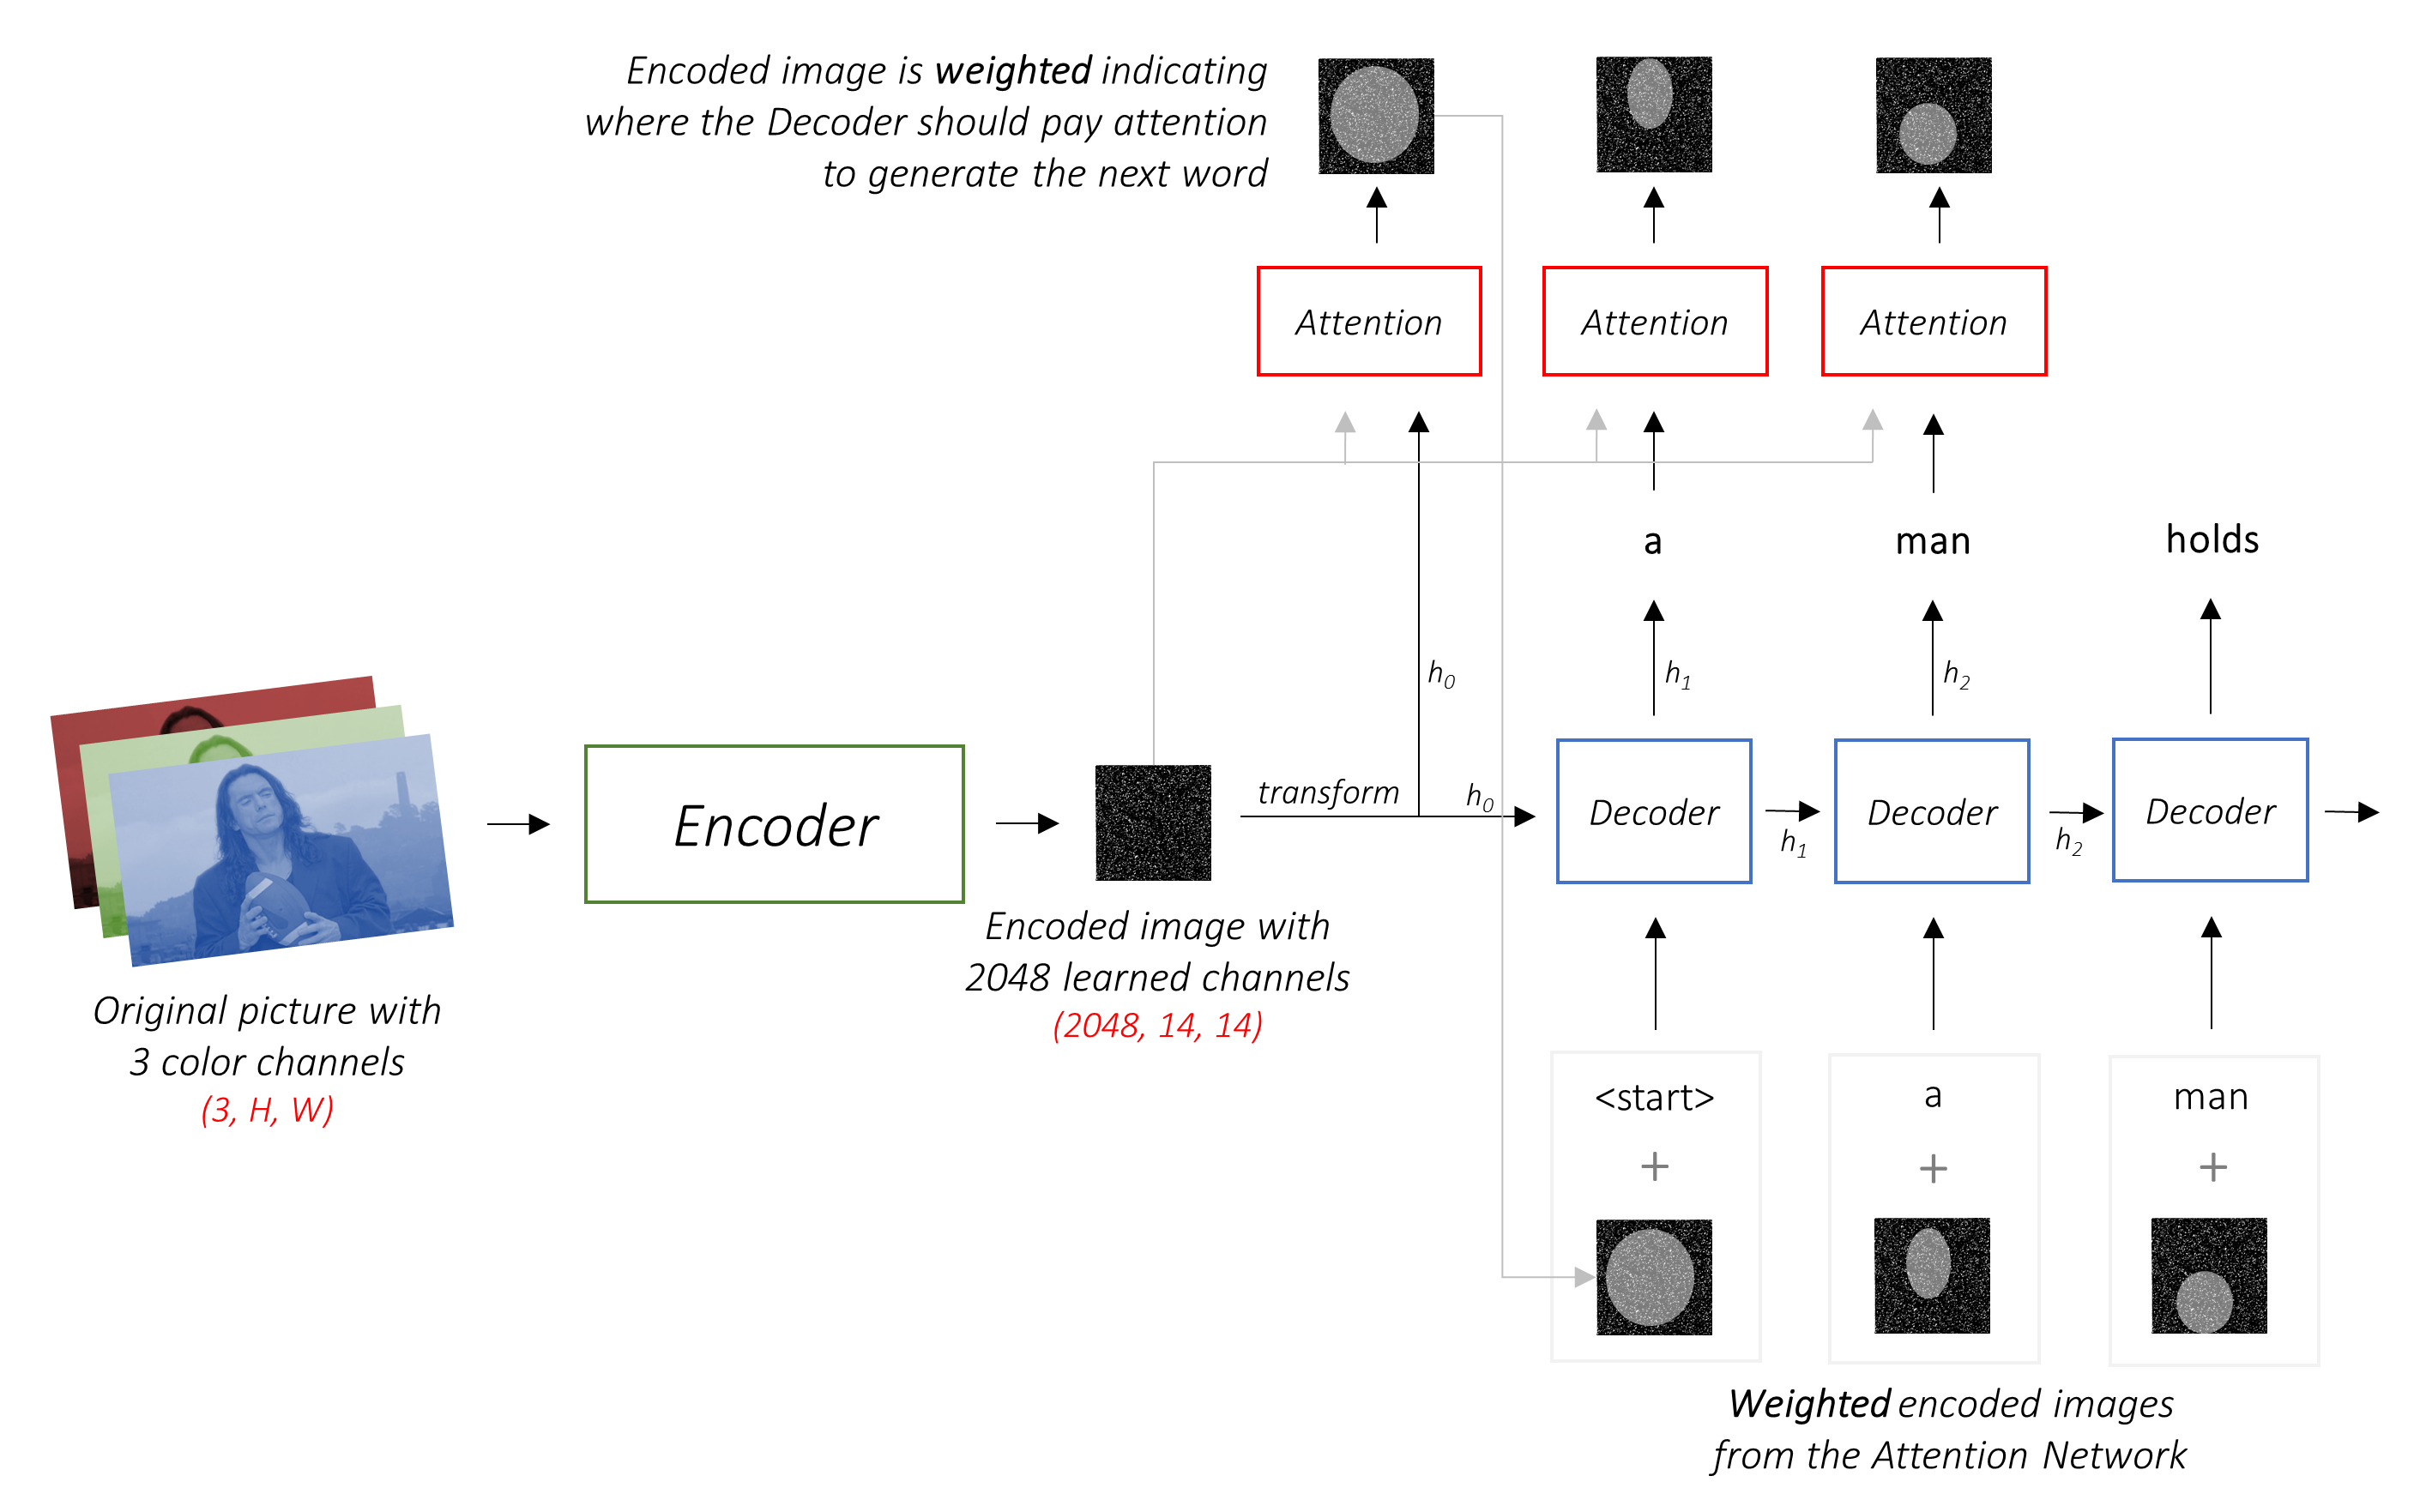

### 2.1 Soft attention and its implementation

Attention
The Attention network computes these weights.

Intuitively, how would you estimate the importance of a certain part of an image? You would need to be aware of the sequence you have generated so far, so you can look at the image and decide what needs describing next. For example, after you mention a man, it is logical to declare that he is holding a football.

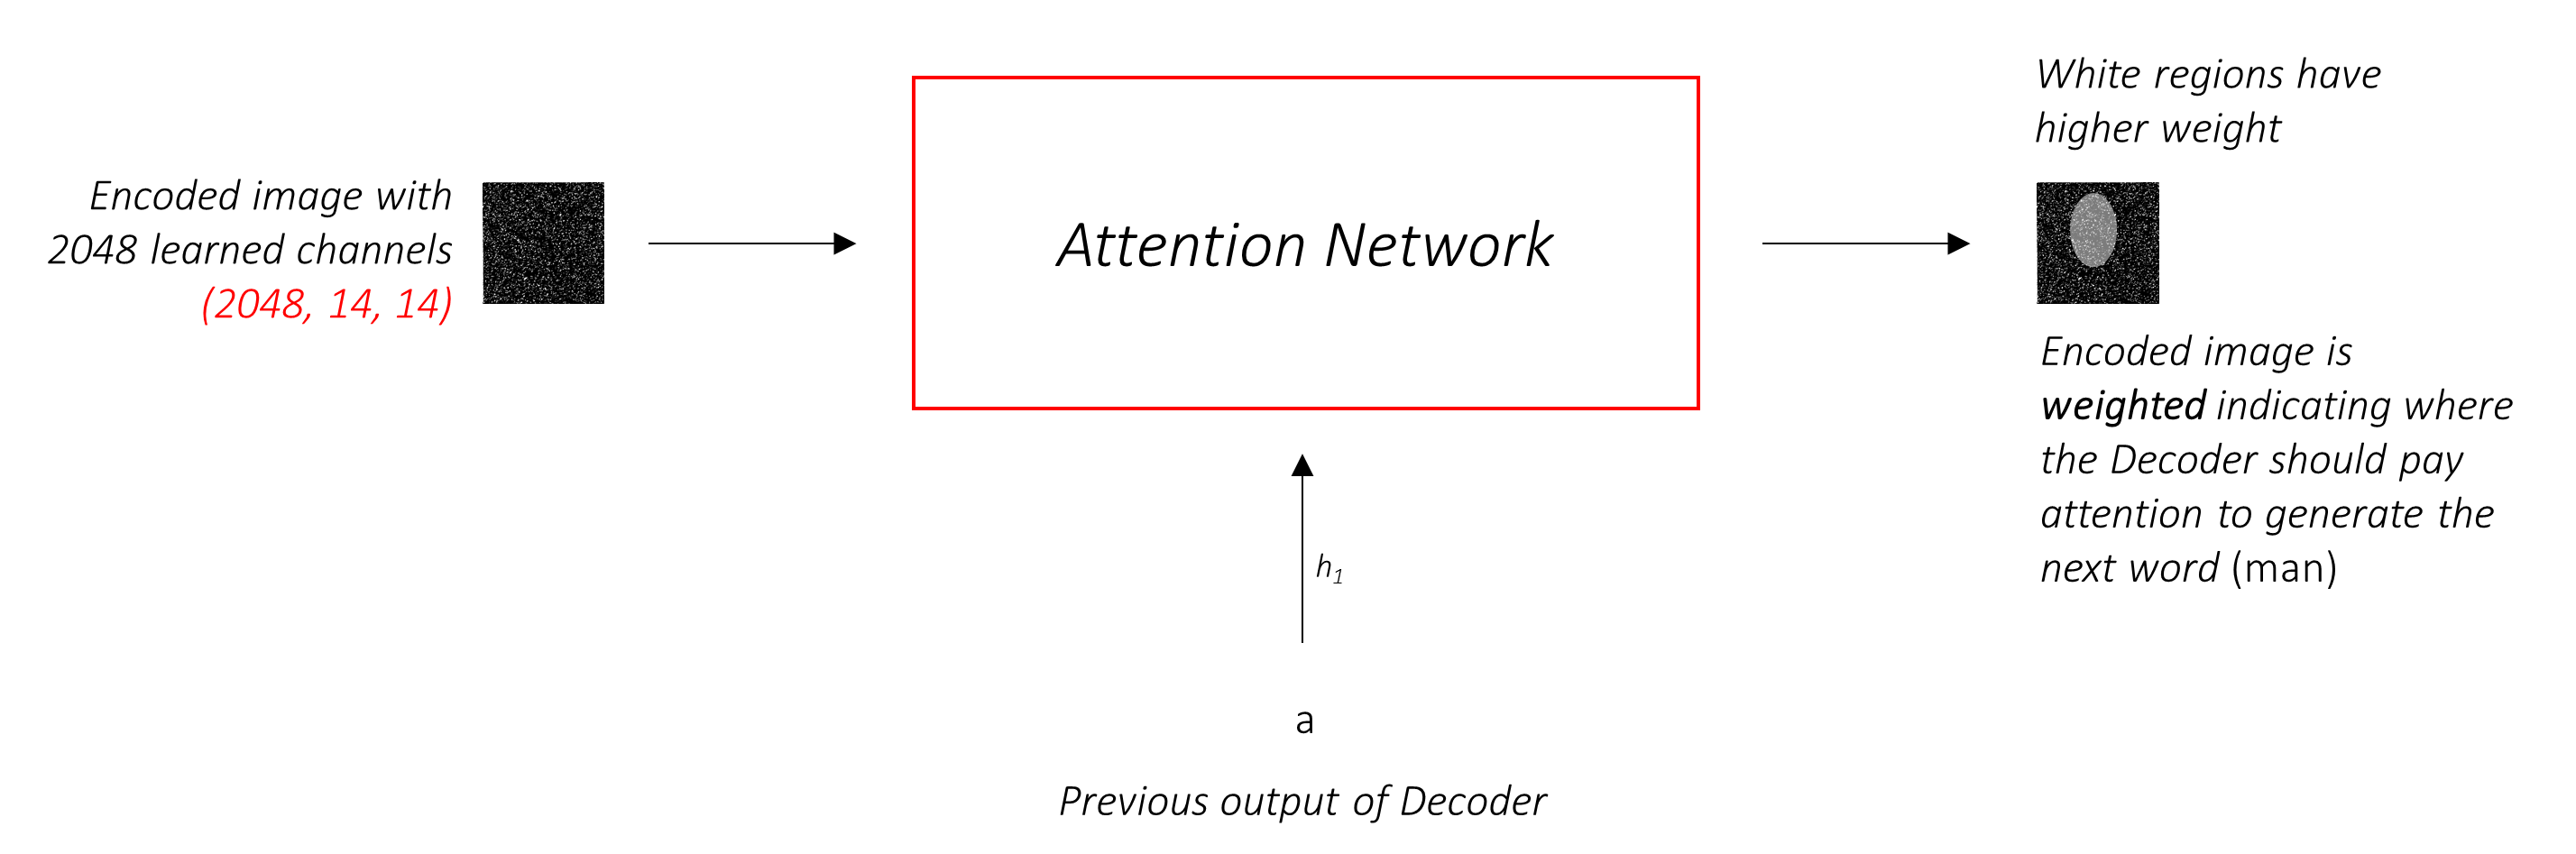

This is exactly what the Attention mechanism does – it considers the sequence generated thus far, and attends to the part of the image that needs describing next.

We will use soft Attention, where the weights of the pixels add up to 1. If there are P pixels in our encoded image, then at each timestep t –

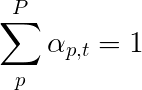


The Attention network is simple – it's composed of only linear layers and a couple of activations.

Separate linear layers transform both the encoded image (flattened to N, 14 * 14, 2048) and the hidden state (output) from the Decoder to the same dimension, viz. the Attention size. They are then added and ReLU activated. A third linear layer transforms this result to a dimension of 1, whereupon we apply the softmax to generate the weights alpha.

In [13]:
class Attention(nn.Module):
    """Attention Network
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        # linear layer to transform encoded image
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        # linear layer to transform decoder's output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        # linear layer to calculate values to be softmax-ed
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        # softmax layer to calculate weights
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension
        (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension
        (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        # (batch_size, num_pixels, attention_dim)
        att1 = self.encoder_att(encoder_out)
        # (batch_size, attention_dim)
        att2 = self.decoder_att(decoder_hidden)
        # (batch_size, num_pixels)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        # (batch_size, num_pixels)
        alpha = self.softmax(att)
        # (batch_size, encoder_dim)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

In [14]:
class DecoderWithAttention(nn.Module):
    """Decoder with attention
    """
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size,
        encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        # Attention network, simple MLP
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        # Different with Decoder defined above
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        # initialize some layers with the uniform distribution
        self.init_weights()

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        # (batch_size, decoder_dim)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        device = encoder_out.device

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(
                encoder_out[:batch_size_t], h[:batch_size_t])
            # Gating scalar, (batch_size_t, encoder_dim)
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :],
                           attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [15]:
# Run your code
batch_size = 2
n_epochs = 5
embed_dim = 512 # dimension of word embeddings
decoder_dim = 512  # dimension of decoder RNN
attention_dim = 512
dropout = 0.5
grad_clip = 5
dataset = Dataset(batch_size = 2)
word_map = dataset.get_word_map()
rev_word_map = dataset.get_rev_word_map()
encoder = Encoder()
decoder = DecoderWithAttention(
                  attention_dim=attention_dim,
                  embed_dim=embed_dim,
                  decoder_dim=decoder_dim,
                  vocab_size=len(word_map),
                  dropout=dropout)
run(encoder, decoder)

>>Epoch(Train): [0][0/250]	Loss 8.9095
>>Epoch(Train): [0][100/250]	Loss 6.1688
>>Epoch(Train): [0][200/250]	Loss 5.8248
>>Epoch(Eval): [0][0/250]	Loss 5.6525
>>Epoch(Eval): [0][100/250]	Loss 5.3804
>>Epoch(Eval): [0][200/250]	Loss 5.3241
>>Epoch(Train): [1][0/250]	Loss 5.5833
>>Epoch(Train): [1][100/250]	Loss 5.1455
>>Epoch(Train): [1][200/250]	Loss 5.1125
>>Epoch(Eval): [1][0/250]	Loss 4.8224
>>Epoch(Eval): [1][100/250]	Loss 5.1279
>>Epoch(Eval): [1][200/250]	Loss 5.1474
>>Epoch(Train): [2][0/250]	Loss 4.9537
>>Epoch(Train): [2][100/250]	Loss 4.9480
>>Epoch(Train): [2][200/250]	Loss 4.9235
>>Epoch(Eval): [2][0/250]	Loss 5.4159
>>Epoch(Eval): [2][100/250]	Loss 5.0720
>>Epoch(Eval): [2][200/250]	Loss 5.0630
>>Epoch(Train): [3][0/250]	Loss 4.1609
>>Epoch(Train): [3][100/250]	Loss 4.6647
>>Epoch(Train): [3][200/250]	Loss 4.6697
>>Epoch(Eval): [3][0/250]	Loss 5.2667
>>Epoch(Eval): [3][100/250]	Loss 4.9551
>>Epoch(Eval): [3][200/250]	Loss 4.9071
>>Epoch(Train): [4][0/250]	Loss 4.0974
>>Epo

## 3. Beam Search when inference

We use a linear layer to transform the Decoder's output into a score for each word in the vocabulary.

The straightforward – and greedy – option would be to choose the word with the highest score and use it to predict the next word. But this is not optimal because the rest of the sequence hinges on that first word you choose. If that choice isn't the best, everything that follows is sub-optimal. And it's not just the first word – each word in the sequence has consequences for the ones that succeed it.

It might very well happen that if you'd chosen the third best word at that first step, and the second best word at the second step, and so on... that would be the best sequence you could generate.

It would be best if we could somehow not decide until we've finished decoding completely, and choose the sequence that has the highest overall score from a basket of candidate sequences.

Beam Search does exactly this.

At the first decode step, consider the top k candidates.
Generate k second words for each of these k first words.
Choose the top k [first word, second word] combinations considering additive scores.
For each of these k second words, choose k third words, choose the top k [first word, second word, third word] combinations.
Repeat at each decode step.
After k sequences terminate, choose the sequence with the best overall score.

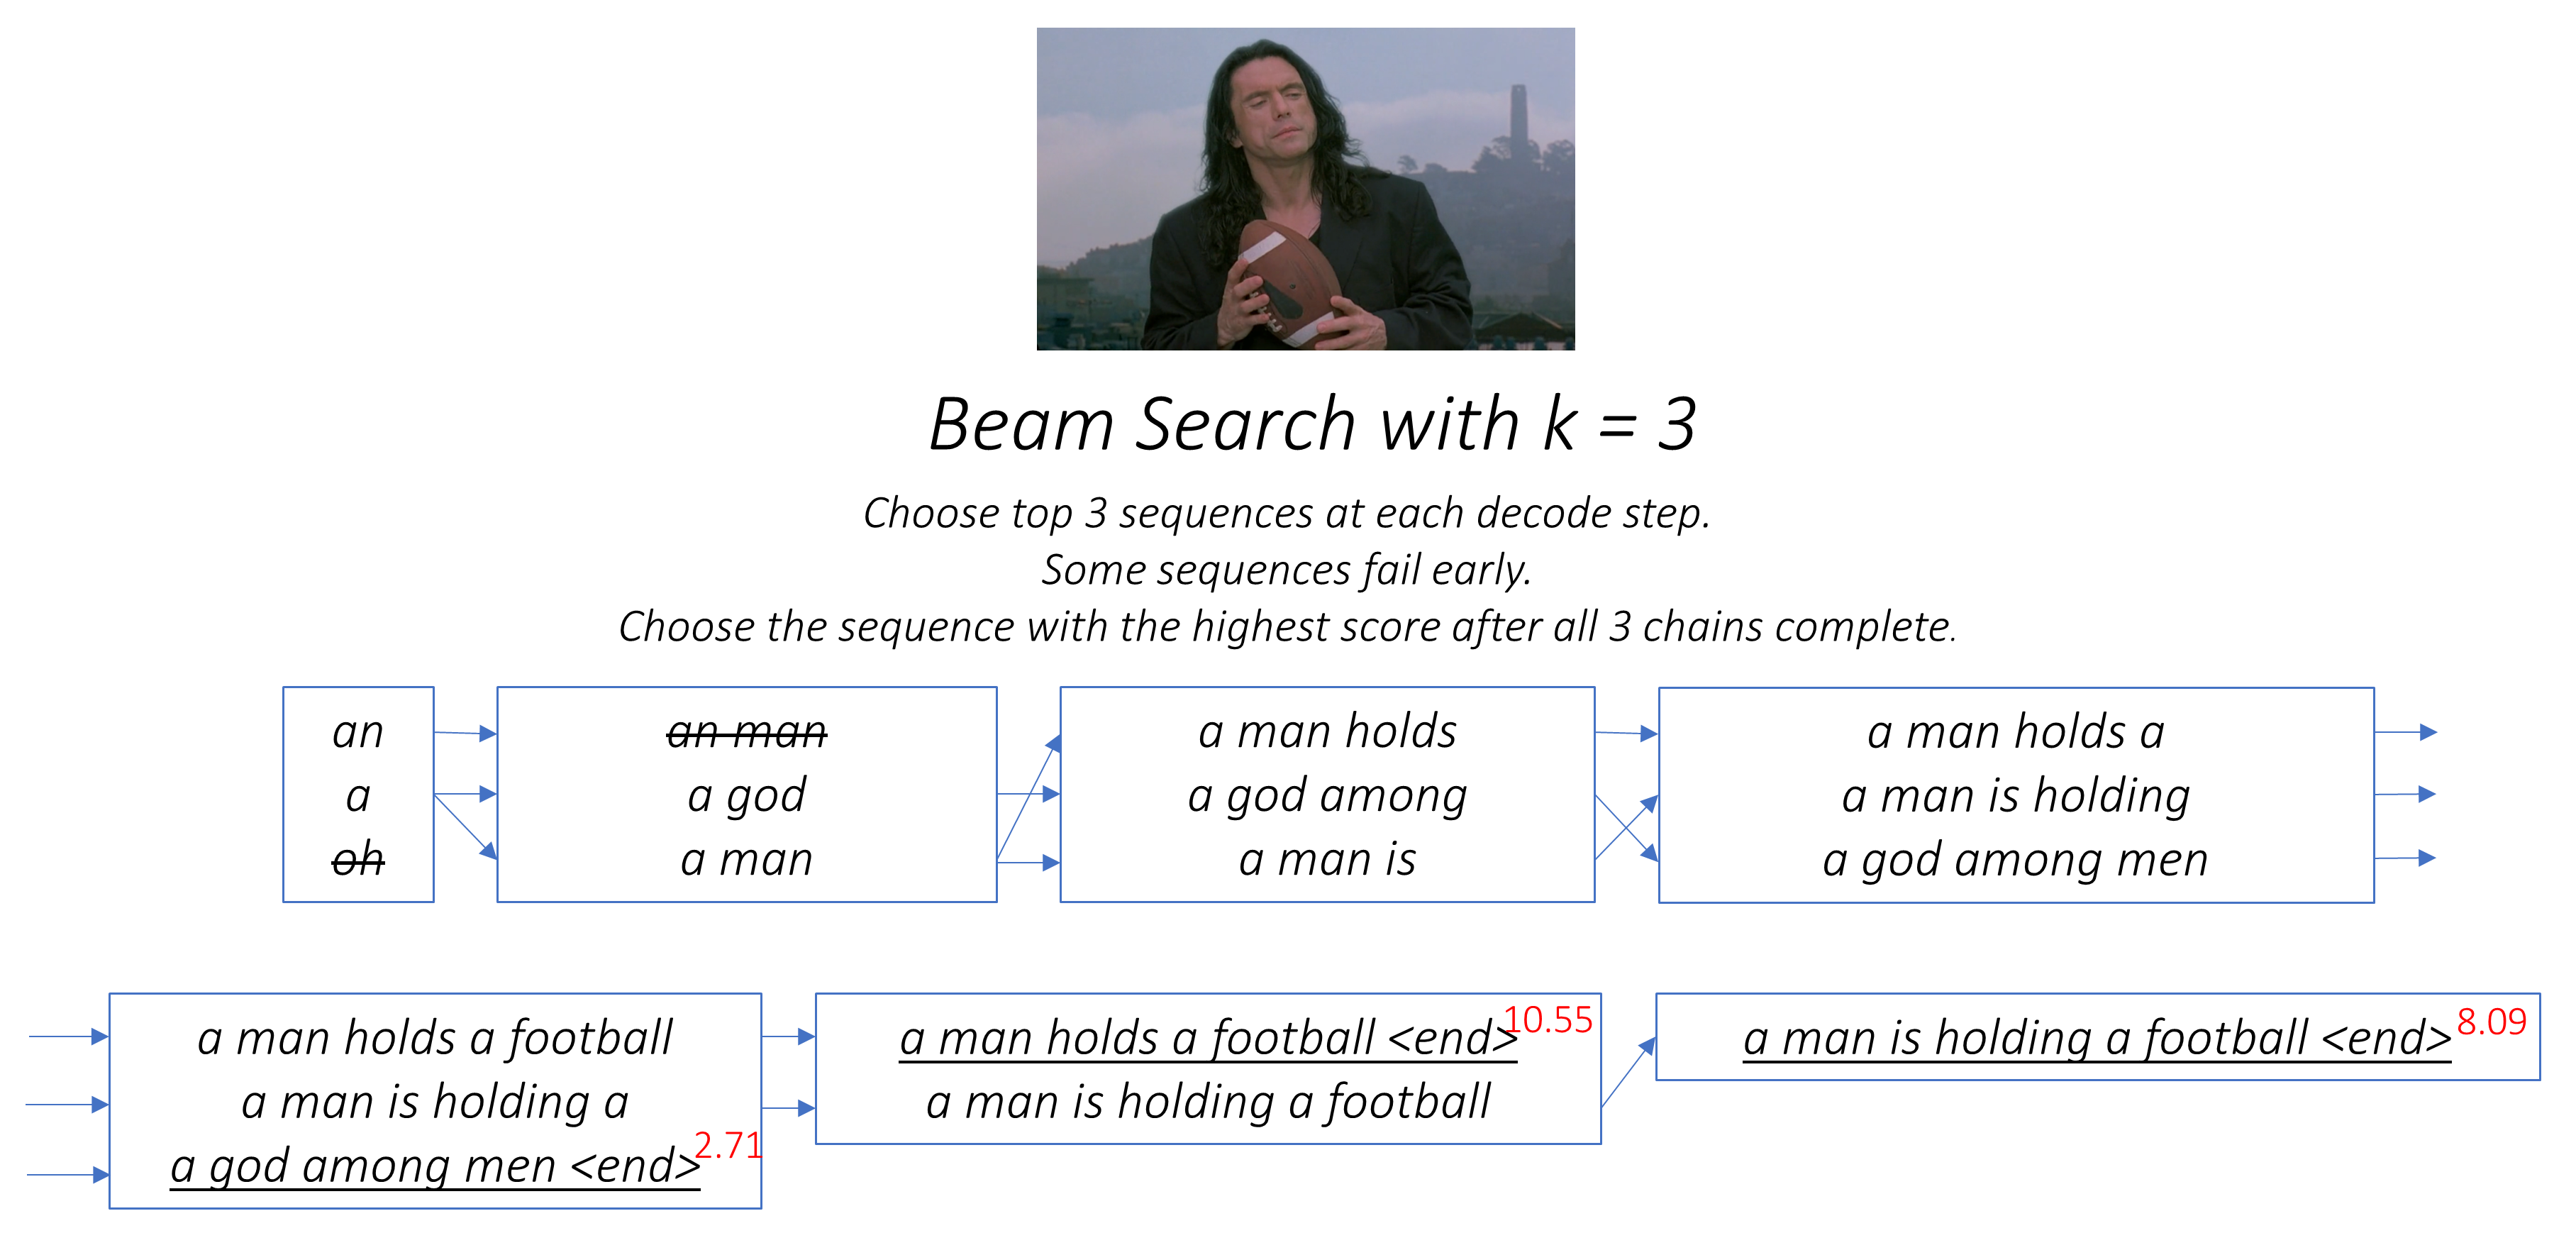

As you can see, some sequences (striked out) may fail early, as they don't make it to the top k at the next step. Once k sequences (underlined) generate the <end> token, we choose the one with the highest score.

In [16]:
def caption_by_beam_search(decoder, encoder_out, word_map, beam_size=5):
    """Caption by beam search

    :param decoder: decoder model
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """
    decoder.eval()
    device = encoder_out.device
    vocab_size = len(word_map)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    enc_image_size = torch.tensor(14)
    # Tensor to store top k previous words at each step;
    # now they're just <start>
    k_prev_words = torch.LongTensor([[word_map["<start>"]]] * beam_size).to(device)
    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(beam_size, 1).to(device)

    # Tensor to store top k sequences' alphas; now they're just 1s
    # (k, 1, enc_image_size, enc_image_size)
    seqs_alpha = torch.ones(beam_size, 1, enc_image_size,
                            enc_image_size).to(device)

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k,
    # because sequences are removed from this process once they hit <end>
    while True:
        # (s, embed_dim)
        embeddings = decoder.embedding(k_prev_words).squeeze(1)
        attention_weighted_encoding, alpha = \
            decoder.attention(encoder_out, h)
        # (s, enc_image_size, enc_image_size)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
        # gating scalar, (s, encoder_dim)
        gate = decoder.sigmoid(decoder.f_beta(h))
        attention_weighted_encoding = gate * attention_weighted_encoding

        # (s, decoder_dim)
        h, c = decoder.decode_step(torch.cat([embeddings, \
            attention_weighted_encoding], dim=1), (h, c))

        # (s, vocab_size)
        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)

        # Add
        # (s, vocab_size)
        scores = top_k_scores.expand_as(scores) + scores

        # For the first step, all k points will have the same
        # scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(beam_size, 0)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(beam_size, 0)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        # (s, step+1)
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)
        # (s, step+1, enc_image_size, enc_image_size)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        # reduce beam length accordingly
        beam_size -= len(complete_inds)

        # Proceed with incomplete sequences
        if beam_size == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas

In [17]:
def visualize_att(seq, alphas, rev_word_map, image_path="./data/1000268201_693b08cb0e.jpg", smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    alphas = torch.FloatTensor(alphas) 
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [18]:
def get_encoded_from_image(encoder, image_path="./data/1000268201_693b08cb0e.jpg", beam_size=5):
    encoder.eval()
    k = beam_size
    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)
    return encoder_out

In [19]:
encoder_out = get_encoded_from_image(encoder)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [20]:
seq, alphas = caption_by_beam_search(decoder, encoder_out, word_map, beam_size=5)

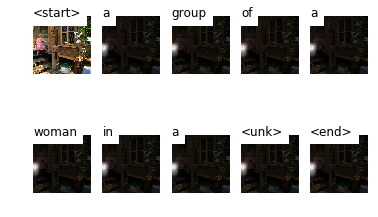

In [22]:
visualize_att(seq, alphas, rev_word_map, image_path="./data/1000268201_693b08cb0e.jpg", smooth=True)

## 作业 2
1. 在学习Seq2seq中我们提到过两种给decoder的LSTM做input的方式，请简单概述，并指出本教程的方式 (Hint：其中一种，teacher-forcing)

答：在Seq2seq中，Decoder的LSTM输入可以是目标句子的targets值，也可以是上一次的Decoder的输出值，即目标句子的预测值。本教程使用的是后者，即将上一次Decoder的输出值作为下一次Decoder的输入值。

2. 在Encoder的代码中将encoder的backbone改为resnet18, 注意到因为resnet18和resnet101的差别，最后产生的channels是不一样的,因而还需要改encoder的代码。多训练几个epoch，调整batch_size的大小（比如32），再使用visualize_att可视化每个单词被翻译出的时候在原图中对应的位置。效果希望尽量的好！（选做）